<a href="https://colab.research.google.com/github/iciromaco/RadiShLab/blob/master/S6_%E3%83%99%E3%82%B8%E3%82%A8%E6%9B%B2%E7%B7%9A%E3%81%82%E3%81%A6%E3%81%AF%E3%82%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N009 補正形状の生成、曲がりに沿った長さと幅の計測
（Generate corrected geometry, measure length and width along a bend）

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,Abs,re,im
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト# 結果の保存

# 予め求めてある左右分割のベジエ近似式を読み込む
fLlist = rd.loadPkl("fLlist.pkl",labhome+"/res") # 左側の近似曲線のリスト
fRlist = rd.loadPkl("fRlist.pkl",labhome+"/res") # 右側の近似曲線のリスト
# 仮中心軸の読み込み
newFC = rd.loadPkl("newFC.pkl",labhome+"/res") # 中心軸の近似曲線のリスト

# 幅の測定

<img src="https://user-images.githubusercontent.com/24559785/77224724-d11ade00-6bab-11ea-9bd2-816d2bd3a380.png" width=200>

「幅」という概念は自明のようでいて定義があいまいである。

たとえば一口に「ダイコンの幅」といった場合、最も太い位置の「幅」とか、「幅」の平均値とか漠然と考えるかもしれないが、ある位置での「幅」はどう定義されるのか？

上の図のA点における幅を考えてみると、A点の反対側で最も近い点までの距離ACでもなく、A点における法線による断面の幅AEでもなく、図のABの長さを多くの人は思い浮かべるが、B点とは何か？というと、線対称図形であれば、対称点なのであろうが、線対称でもない図形における対称点など定義できない。「A点の反対側」という概念も、左右の境界を想定していて初めて成り立つ。

どこか頭の奥でダイコンは本来左右対称であること、つまり「中心軸」を持つという頭があるからこそ反対側とか、幅とかいう概念が成立するのである。

ありていに言えば対称図形でもないものに対して幅は定義できないので、ここでは我田引水的であはるが、合成で求めた曲線を中心軸とみなし、その各点における法線とシルエットの断面の幅をもって「幅」と定義することにする。

# 数式上で求解

左右。中心軸ともにパラメータｔだけの関数として数式で表現されている。
中心軸上の任意の点を通る法線と左右の輪郭との交点はｔに関する連立方程式を解けば求めうる。

未知数一つの多項式の連立方程式なので sympy の solve で解くことができる。

# **crossPointsLRonEx()**
> **crossPointsLRonEx(fl,fr,fc,t0)**
> 入力
>>    **fl,fr,fc**  左右中央のベジエ曲線
>>    **t0** 位置を特定するパラメータ

> 出力
>>    中央の曲線のパラメータ t0 の点の法線と左右の輪郭との交点座標

```
def crossPointsLRonEx(fl,fr,fc,t0):
        # fl,fr,fc 左側、右側、中心線のパラメトリック曲線
        # t0 曲線上の位置を特定するパラメータ
        t = symbols('t')
        fcx,fcy = fc
        flx,fly = fl
        frx,fry = fr
        dcx,dcy = diff(fcx,t),diff(fcy,t)
        x0 = float(fcx.subs(t,t0)) # (x0,y0) 中心軸上の点
        y0 = float(fcy.subs(t,t0))
        dx0 = float(dcx.subs(t,t0)) # dx/dt
        dy0 = float(dcy.subs(t,t0)) # dy/dt
       
        ans = solve(-dx0/dy0*(frx-x0)+ y0-fry,t) # 法線とベジエ輪郭の交点
        ansR = [re(i) for i in ans if float(Abs(im(i)))<0.00000001] 

        sr = [i for i in ansR if  i<=1.03 and -0.03<=i] 
        rdata = [int(float(frx.subs(t,sr[0]))),int(float(fry.subs(t,sr[0])))] \
            if sr !=[] else [np.inf,np.inf]
        ans = solve(-dx0/dy0*(flx-x0)+y0-fly,t) # 法線とベジエ輪郭の交点を求める
        ansL = [re(i) for i in ans if float(Abs(im(i)))<0.00000001]
        sl = [i for i in ansL if i<=1.03 and -0.03<=i]
        ldata = [int(float(flx.subs(t,sl[0]))),int(float(fly.subs(t,sl[0])))] \
            if sl !=[] else [np.inf,np.inf]
        
        return ldata,rdata
```


In [2]:
# 中心線の法線と輪郭の交点を数式解法で求めて結ぶ
def NormalLadder(num,n_samples=10):
    img = imgs[num]
    fl = fLlist[num]
    fr = fRlist[num]
    fc = newFC[num]
    dp = rd.getDenseParameters(fc,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    samples = np.array([[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in dp])
    # 上端点における法線は両サイドと交差しないことが多いので計算せずに端点をそのまま採用
    lpoints = [[int(float(fl[0].subs('t',0))),int(float(fl[1].subs('t',0)))]]
    rpoints = [[int(float(fr[0].subs('t',0))),int(float(fr[1].subs('t',0)))]]
    for s in dp[1:-1]:
        ldata,rdata = rd.crossPointsLRonEx(fl,fr,fc,s)
        lpoints.append(ldata)
        rpoints.append(rdata)
        print(ldata,rdata)
    # 下端点における端点も計算せずにそのまま採用
    lpoints.append([int(float(fl[0].subs('t',1))),int(float(fl[1].subs('t',1)))])
    rpoints.append([int(float(fr[0].subs('t',1))),int(float(fr[1].subs('t',1)))])
    lpoints = np.array(lpoints)
    rpoints = np.array(rpoints)
    rd.drawBez0(img,stt=0.0,end=1.0,bezL=fl,bezR=fr,bezC=fc,PosL=lpoints,PosR=rpoints,PosC=samples,ladder='normal',ct=list("0123456789"))

[69, 64] [232, 55]
[64, 91] [241, 80]
[66, 117] [241, 107]
[83, 148] [226, 141]
[123, 172] [193, 170]
[144, 197] [172, 197]
[147, 229] [165, 231]
[145, 255] [161, 257]
Wall time: 7min 7s


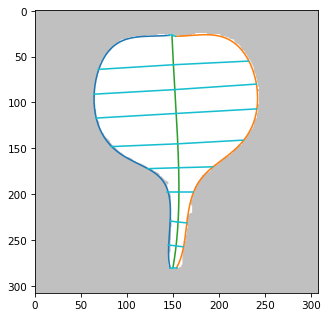

In [3]:
%%time
plt.figure(figsize=(10,5),dpi=75)
NormalLadder(1,n_samples=10) #時間がかかるのでサンプル数は大きくしないほうがよい

[140, 53] [181, 65]
[132, 78] [171, 92]
[125, 105] [163, 116]
[119, 142] [156, 146]
[119, 172] [153, 170]
[126, 201] [155, 195]
[142, 234] [162, 226]
[154, 258] [168, 253]
Wall time: 7min 9s


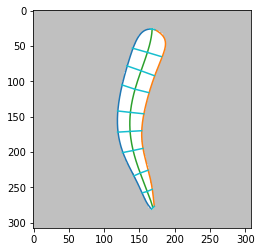

In [4]:
%%time
NormalLadder(2,n_samples=10)

[111, 56] [192, 61]
[112, 84] [191, 86]
[113, 111] [189, 111]
[107, 145] [193, 143]
[100, 172] [201, 169]
[93, 198] [210, 195]
[89, 230] [218, 229]
[97, 255] [209, 257]
Wall time: 5min 57s


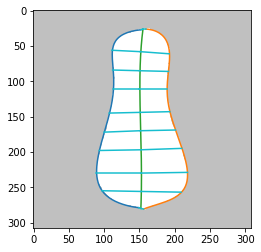

In [5]:
%%time
NormalLadder(0,n_samples=10)

方程式の解は複素数含めて、次数と同じだけの解が出てくる。実解のうちのひとつで[0,1]区間となるものを取り出すようにプログラムしている。

また、中心軸を再近次していないと頭頂付近で折り返すような関数となることが多く、その場合法線方向が予想外の向きとなるので異常な解となりやすい。

再近次で得た曲線は縦方向を向くようになるため、解が異常値となることは少ないが、左右の曲線もまた頭頂付近で湾曲するため妥当な交点が求まらないことが多い。そのため両端点については交点を求めず元の端点をそのまま採用している。


数式上で解が得られるので、プログラミングは楽だが、左右のベジエ曲線の次数が高いので場所によっては方程式を解くのにすごく時間がかかってしまう。

 # 画像処理による交点計算
 
 次のプログラムは輪郭線と中心軸の法線との交点を画像処理的に求めるプログラムである。
 
 
# **crossPointsLRonImg()**
> 図的処理によりベジエ曲線の法線と図形輪郭の交点を求める 

> **rd.crossPointsLRonEx(img,fc,t0)**   
> 入力
>>    **img** 画像
>>    **fc**  ベジエ曲線
>>    **t0** 位置を特定するパラメータ

> 出力
>>    入力画像の輪郭と中央の曲線のパラメータ t0 の点の法線との左右の交点座標

# **crossPointsLRbyImg0()**
> **rd.crossPointsLRonEx0(img,x0,y0,dx,dy)**   
> 入力
>>    **img** 画像  
>>    **x0,y0** 直線上の１点  
>>    **dx,dy** 直線の傾き

> 出力は同上

In [6]:
# 図的解法で求めた垂線による断面を描画するプログラム
def NormalLadder20(img,fl,fr,fc,num,n_samples=32):
    #dpl = rd.getDenseParameters(fl,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    #dpr = rd.getDenseParameters(fr,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    dp = rd.getDenseParameters(fc,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    samples = np.array([[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in dp])
    # 上端点における法線は両サイドと交差しないことが多いので計算せずに端点をそのまま採用
    lpoints = [[int(float(fl[0].subs('t',0))),int(float(fl[1].subs('t',0)))]]
    rpoints = [[int(float(fr[0].subs('t',0))),int(float(fr[1].subs('t',0)))]]
    for t0 in dp[1:-1]:
        ldata,rdata = rd.crossPointsLRonImg(img,fc,t0) # 中心線 fcのパラメータ t0の点の法線と画像輪郭の交点を図的に求める
        lpoints.append(ldata)
        rpoints.append(rdata)
    # 下端点における端点も計算せずにそのまま採用
    lpoints.append([int(float(fl[0].subs('t',1))),int(float(fl[1].subs('t',1)))])
    rpoints.append([int(float(fr[0].subs('t',1))),int(float(fr[1].subs('t',1)))])
    lpoints = np.array(lpoints)
    rpoints = np.array(rpoints)
    return lpoints,rpoints,samples,dp
    
def NormalLadder2(num,n_samples=32):
    img = imgs[num]
    fl = fLlist[num]
    fr = fRlist[num]
    fc = newFC[num]
    lpoints,rpoints,samples,_dp = NormalLadder20(img,fl,fr,fc,num,n_samples=n_samples)
    rd.drawBez0(img,stt=0.0,end=1.0,bezL=fl,bezR=fr,bezC=fc,PosL=lpoints,PosR=rpoints,PosC=samples,ladder='normal',ct=list("0123456789"))

Wall time: 5.57 s


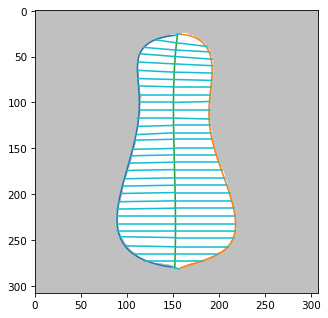

In [7]:
%%time
plt.figure(figsize=(10,5),dpi=75)
NormalLadder2(0,n_samples=32) # 図的解法は比較的高速なのでサンプル数を大きくとれる

意外なことに、画像処理的に求めた方が圧倒的に早い。画素単位でしか求められないので内部的な精度は落ちるわけであるが、表示して評価する限りにおいては厳密解とほとんど違いは判らない。

画像の輪郭をもとに計算するので、もともと近似曲線と画像との間でずれが生じている部分は梯子を描いた際にずれが生じるはずであるが、これまでの実験データにおいては近似誤差は平均１画素内に収まっているので気づかない程度の違いである。

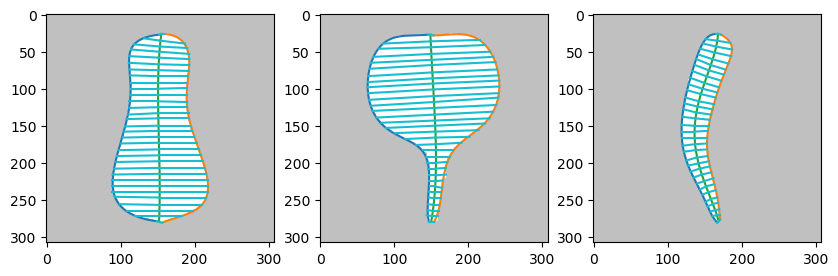

In [8]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(131)
NormalLadder2(0,n_samples=32)
plt.subplot(132)
NormalLadder2(1,n_samples=32)
plt.subplot(133)
NormalLadder2(2,n_samples=32)

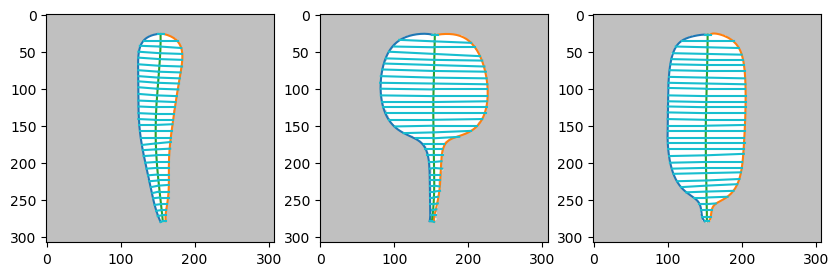

In [9]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(131)
NormalLadder2(3,n_samples=32)
plt.subplot(132)
NormalLadder2(4,n_samples=32)
plt.subplot(133)
NormalLadder2(5,n_samples=32)

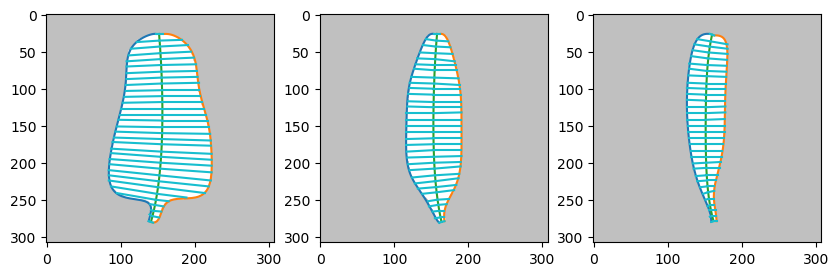

In [10]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(131)
NormalLadder2(6,n_samples=32)
plt.subplot(132)
NormalLadder2(7,n_samples=32)
plt.subplot(133)
NormalLadder2(8,n_samples=32)

Wall time: 5.6 s


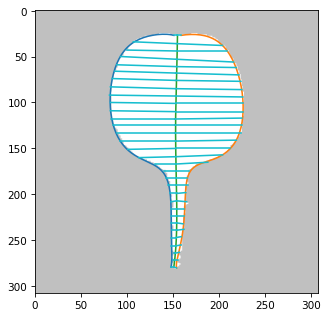

In [11]:
%%time
plt.figure(figsize=(10,5),dpi=75)
NormalLadder2(4,n_samples=32) # 図的解法は比較的高速なのでサンプル数を大きくとれる

中心軸上でサンプル点を等間隔に採った場合、輪郭のX方向の変分が大きい箇所においてサンプル点がまばらになる。

### 輪郭線上でサンプル点がなるべく等間隔となるようにする方法

次のプログラムは輪郭上でサンプル点がなるべく等間隔となるように工夫したプログラムである。

1. 左右の輪郭上に等間隔に点列 $spl_n$, $spr_n$ $n=0,1,2 \cdots$を取る。
2. 線分$spl_n spr_n$と中心線の交点を求める→ $cpoints$。４次関数なので数式上のソルバーでも比較的短時間で解ける。  
3. 交点の法線と両側の交点を求める。→　$lpoints,rpoints$　こちらは高次で計算量が大きいので図的解を利用。


In [12]:
# 図的解法で求めた垂線による断面を描画するプログラム
def NormalLadder30(img,fl,fr,fc,n_samples=32):
    t = symbols('t')
    dpl = rd.getDenseParameters(fl,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    dpr = rd.getDenseParameters(fr,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    spl = lpoints = np.array([[int(float(fl[0].subs(t,s))),int(float(fl[1].subs(t,s)))] for s in dpl])
    spr = rpoints = np.array([[int(float(fr[0].subs(t,s))),int(float(fr[1].subs(t,s)))] for s in dpr])
    
    fcx,fcy = fc
    cpoints = [] # 左右の対応点を結ぶ線分と中心線の交点
    dpc = [] # その点のパラメータ
    for [xl,yl],[xr,yr] in zip(spl,spr):
        print('.',end='')
        ans = solve((xr-fcx)*(fcy-yl)-(fcx-xl)*(yr-fcy),t) # 左右の等間隔点を結ぶ線分と中心線の交点
        ansR = [re(i) for i in ans if float(Abs(im(i)))<0.00000001] # 解の実部
        sc = [i for i in ansR if i<=1.02 and -0.02<=i] # ０から１までの範囲の解を抽出 
        cpoints.append([int(float(fcx.subs(t,sc[0]))),int(float(fcy.subs(t,sc[0])))] if sc !=[] else [np.inf,np.inf])
        dpc.append(sc[0] if sc !=[] else np.inf)
    if dpc[0] == np.inf:
        dpc[0] = 0
        cpoints[0] = [int(float(fc[0].subs(t,0))),int(float(fc[1].subs(t,0)))]
    if dpc[-1] == np.inf:
        dpc[-1] = 1
        cpoints[-1] = [int(float(fc[0].subs(t,1))),int(float(fc[1].subs(t,1)))]
    cpoints = np.array(cpoints)
    
    # 上端点における法線は両サイドと交差しないことが多いので計算せずに端点をそのまま採用
    lpoints2 = [[int(float(fl[0].subs(t,0))),int(float(fl[1].subs(t,0)))]]
    rpoints2 = [[int(float(fr[0].subs(t,0))),int(float(fr[1].subs(t,0)))]]
    for t0 in dpc[1:-1]:
        ldata,rdata = rd.crossPointsLRonImg(img,fc,t0) # 中心線 fcのパラメータ t0の点の法線と画像輪郭の交点を図的に求める
        lpoints2.append(ldata)
        rpoints2.append(rdata)
    # 下端点における端点も計算せずにそのまま採用
    lpoints2.append([int(float(fl[0].subs(t,1))),int(float(fl[1].subs(t,1)))])
    rpoints2.append([int(float(fr[0].subs(t,1))),int(float(fr[1].subs(t,1)))])
    lpoints2 = np.array(lpoints2)
    rpoints2 = np.array(rpoints2)
    return lpoints2,rpoints2,cpoints,dpc
        
def NormalLadder3(num,n_samples=32):
    img = imgs[num]
    fl = fLlist[num]
    fr = fRlist[num]
    fc = newFC[num]
    lpoints,rpoints,cpoints,_dpc = NormalLadder30(img,fl,fr,fc,n_samples=n_samples)
    rd.drawBez0(img,stt=0.0,end=1.0,bezL=fl,bezR=fr,bezC=fc,PosL=lpoints,PosR=rpoints,PosC=cpoints,ladder='normal',ct=list("0123456789"))

................................Wall time: 33.1 s


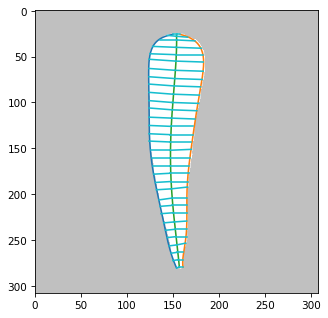

In [13]:
%%time
plt.figure(figsize=(10,5),dpi=75)
NormalLadder3(3,n_samples=32) 

................................Wall time: 37.3 s


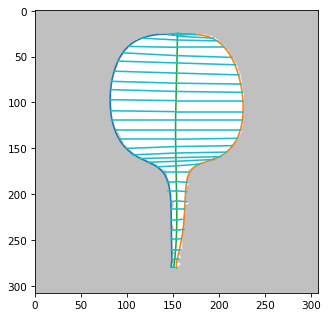

In [14]:
%%time
plt.figure(figsize=(10,5),dpi=75)
NormalLadder3(4,n_samples=32) 

................................Wall time: 40.9 s


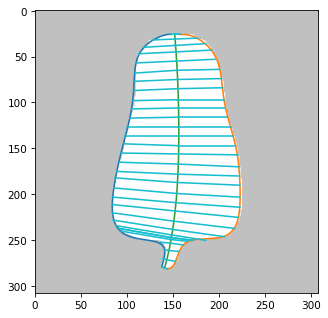

In [15]:
%%time
plt.figure(figsize=(10,5),dpi=75)
NormalLadder3(6,n_samples=32) 

### 比較

................................Wall time: 46.7 s


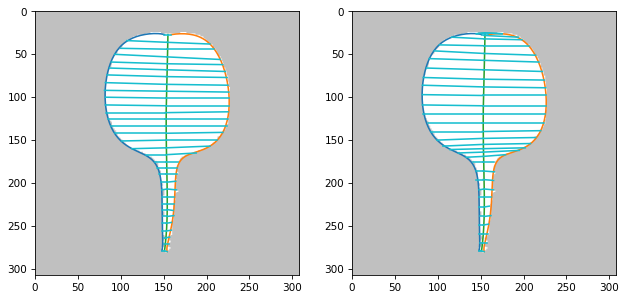

In [16]:
%%time
plt.figure(figsize=(10,5),dpi=75)
plt.subplot(121)
NormalLadder2(4,n_samples=32) 
plt.subplot(122)
NormalLadder3(4,n_samples=32) 

# 曲がり補正と計測

中心線の各点における垂直断面の長さを **「幅」**、中心線に沿って測った経路長を個体の **「長さ」** と定義しよう。

（仮ではあるが）中心線が得られたので縦軸を中心線上端からの距離、横軸を幅にとってプロットすれば、曲がりがなかった場合の形状を合成することができる。


やってみよう。

In [17]:
# 形状補正

# 計算不能箇所のデータの補間
def interporation(plist):
    while np.sum(plist) == np.inf: # np.inf を含むなら除去を繰り返す
        for i in range(len(plist)):
            if np.sum(plist[i]) == np.inf :
                print("欠",end="")
                if (i !=0 and i !=len(plist)-1) and np.sum(plist[i-1]+plist[i+1]) != np.inf: # 当該は無限で、前後は無限ではない場合
                    plist = np.r_[plist[0:i],[[int(round(((plist[i-1]+plist[i+1])/2)[0])),
                                              int(round(((plist[i-1]+plist[i+1])/2)[1]))]],plist[i+1:]]
                elif len(plist[i:])>=3 and np.sum(plist[i+1]+plist[i+2]) != np.inf:
                    plist = np.r_[plist[0:i],[plist[i+2]-2*(plist[i+2]-plist[i+1])],plist[i+1:]]
                elif len(plist[0:i])>=2 and np.sum(plist[i-1]+plist[i-2]) != np.inf:
                    plist = np.r_[plist[0:i],[plist[i-2]-2*(plist[i-2]-plist[i-1])],plist[i+1:]]
    return plist

# 補正形状を求める
def reformRadish(num,N=8,topZero=True):
    img = imgs[num] 
    fl = fLlist[num]
    fr = fRlist[num]
    fc = newFC[num]
    lpoints2,rpoints2,cpoints,dpc = NormalLadder30(img,fl,fr,fc,n_samples=24)
    print("\nPair Detection Complete")

    # 各サンプル点における幅を求める
    lpoints2 = interporation(lpoints2)
    rpoints2 = interporation(rpoints2)
    width = []
    for [lx,ly],[rx,ry] in zip(lpoints2,rpoints2):
        w = np.sqrt((lx-rx)*(lx-rx)+(ly-ry)*(ly-ry))
        width.append(w)
    print("Width Samples Collected")

    # 各サンプル点までの距離を求める
    dp,lengths = rd.getDenseParameters(fc,n_samples=128,span=0,needlength=True)
    found = [0.0]
    i = 1
    for n in range(1,len(dpc)-1):
        t = dpc[n]
        while dp[i] < t:
            i = i+1
        if t == dp[i]:
            found.append(lengths[i])
        else:
            found.append(((dp[i]-t)*lengths[i-1]+(t-dp[i-1])*lengths[i])/(dp[i]-dp[i-1]))
    found.append(lengths[-1])

    if topZero :
        width = [0]+width+[0] # 少し姑息だが　端点を閉じる目的　
        found = [found[0]]+found+[found[-1]]
        
    # 形状補正データのサンプルの生成
    samples = np.array([[int(round(l)),int(round(w))] for l,w in zip(width,found)])
    
    bez = rd.BezierCurve(N=N,samples=samples) # インスタンス生成
    cps,fc = bez.fit1(maxTry=10)
    print(cps)
    # 結果の描画
    gx,gy,(x,y,w,h,a) = rd.getCoG(img)
    rd.drawBez(rdimg=img,stt=0.0,end=1.0,bezL=[-fc[0]/2,y+fc[1]],bezR=[fc[0]/2,y+fc[1]])

    print("補正後の全長は {:3.1f} pixels".format(found[-1]))
    print("最大幅は {:3.1f} pixels".format(np.array(width).max()))
    return fc

In [18]:
rd.BezierCurve.setParameters()

AsymptoticPriority :  distance
dCount    :  7
driftThres:  0.03
errorThres:  0.01
debugmode :  False
openmode  :  False



........................
Pair Detection Complete
Width Samples Collected

..........
[[0.0, 0.0], [-23.278052609518607, 8.708287248757104], [361.98038129802484, -55.896019961720484], [-166.00018779325484, 292.21276483004857], [-42.66577669203975, -78.73837429636355], [512.0154855838988, 367.5936949104345], [-41.34541200927854, 216.0351213877299], [77.74890262371929, 258.9569729074699], [0.0, 259.0]]
補正後の全長は 259.2 pixels
最大幅は 129.0 pixels


Matrix([
[             77.7489026237193*t**7*(8 - 8*t) - 1157.6715362598*t**6*(1 - t)**2 + 28672.8671926983*t**5*(1 - t)**3 - 2986.60436844278*t**4*(1 - t)**4 - 9296.01051642227*t**3*(1 - t)**5 + 10135.4506763447*t**2*(1 - t)**6 - 186.224420876149*t*(1 - t)**7],
[259.0*t**8 + 258.95697290747*t**7*(8 - 8*t) + 6048.98339885644*t**6*(1 - t)**2 + 20585.2469149843*t**5*(1 - t)**3 - 5511.68620074545*t**4*(1 - t)**4 + 16363.9148304827*t**3*(1 - t)**5 - 1565.08855892817*t**2*(1 - t)**6 + 69.6662979900568*t*(1 - t)**7]])

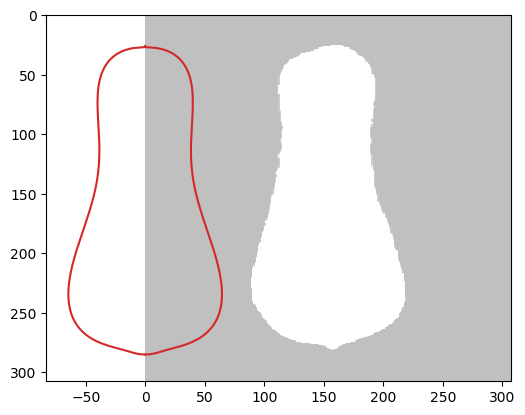

In [19]:
fc = reformRadish(0,N=8)
fc

........................
Pair Detection Complete
欠欠欠Width Samples Collected

......
[[0.0, 0.0], [97.86113005136133, -12.02954123503457], [-53.417089300677894, 81.07587196459082], [492.0357595592309, -263.0254841520686], [60.746750785654314, 436.341980170789], [262.357811791089, 73.45007174413284], [-136.1902815130654, 51.22779854608888], [75.35793843368899, 251.9214882580025], [0.0, 260.0]]
補正後の全長は 259.6 pixels
最大幅は 177.2 pixels


Matrix([
[                75.357938433689*t**7*(8 - 8*t) - 3813.32788236583*t**6*(1 - t)**2 + 14692.037460301*t**5*(1 - t)**3 + 4252.2725549958*t**4*(1 - t)**4 + 27554.0025353169*t**3*(1 - t)**5 - 1495.67850041898*t**2*(1 - t)**6 + 782.889040410891*t*(1 - t)**7],
[260.0*t**8 + 251.921488258003*t**7*(8 - 8*t) + 1434.37835929049*t**6*(1 - t)**2 + 4113.20401767144*t**5*(1 - t)**3 + 30543.9386119552*t**4*(1 - t)**4 - 14729.4271125158*t**3*(1 - t)**5 + 2270.12441500854*t**2*(1 - t)**6 - 96.2363298802766*t*(1 - t)**7]])

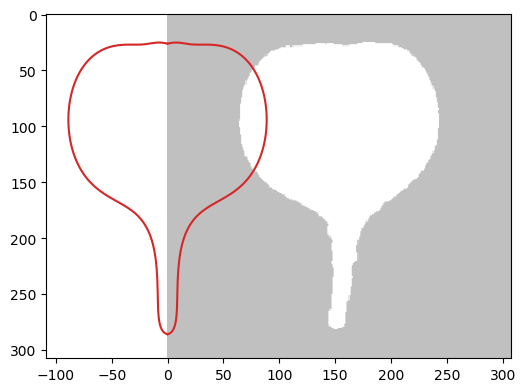

In [20]:
fc = reformRadish(1,N=8)
fc

この個体のように頭頂部にひずみがあり、水平に近い個体は、頭頂部は近似自体も難しいし、幅の計測点が取れないため補正形状もおかしくなる。

........................
Pair Detection Complete
Width Samples Collected

.......
[[0.0, 0.0], [62.96889077606467, 11.679013160004642], [68.58339143159715, -25.471781176881752], [-24.12979884097364, 301.1933791061563], [104.80942482403206, -130.58596861952987], [0.06844953354938284, 417.2400003161457], [25.76306901489977, 91.44780858522499], [27.97582021308339, 309.9469380875355], [0.0, 300.0]]
補正後の全長は 300.4 pixels
最大幅は 43.0 pixels


Matrix([
[            27.9758202130834*t**7*(8 - 8*t) + 721.365932417194*t**6*(1 - t)**2 + 3.83317387876544*t**5*(1 - t)**3 + 7336.65973768224*t**4*(1 - t)**4 - 1351.26873509452*t**3*(1 - t)**5 + 1920.33496008472*t**2*(1 - t)**6 + 503.751126208517*t*(1 - t)**7],
[300.0*t**8 + 309.946938087536*t**7*(8 - 8*t) + 2560.5386403863*t**6*(1 - t)**2 + 23365.4400177042*t**5*(1 - t)**3 - 9141.01780336709*t**4*(1 - t)**4 + 16866.8292299448*t**3*(1 - t)**5 - 713.209872952689*t**2*(1 - t)**6 + 93.4321052800371*t*(1 - t)**7]])

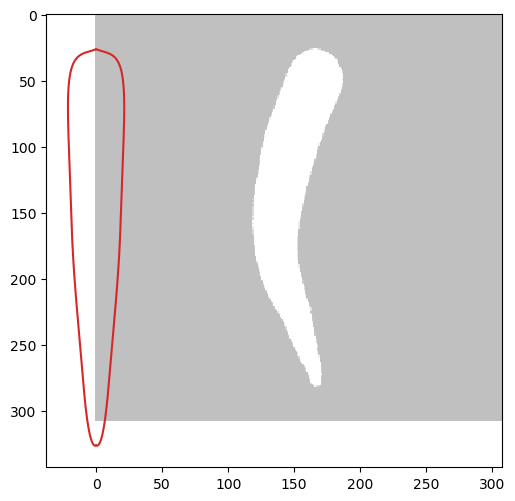

In [21]:
fc =reformRadish(2)
fc

In [22]:
fc.subs('t',0)

Matrix([
[0],
[0]])

........................
Pair Detection Complete
Width Samples Collected

........
[[0.0, 0.0], [13.13472171676104, 7.453631607459244], [223.2057206245329, -43.90629053231188], [-157.22631487398576, 226.34090544465244], [229.337411602606, -71.41331128652054], [-59.10781404503312, 333.73101229606283], [53.227993050400734, 81.70727566899897], [25.52186015933219, 278.596064939255], [0.0, 265.0]]
補正後の全長は 265.3 pixels
最大幅は 59.1 pixels


Matrix([
[             25.5218601593322*t**7*(8 - 8*t) + 1490.38380541122*t**6*(1 - t)**2 - 3310.03758652185*t**5*(1 - t)**3 + 16053.6188121824*t**4*(1 - t)**4 - 8804.6736329432*t**3*(1 - t)**5 + 6249.76017748692*t**2*(1 - t)**6 + 105.077773734088*t*(1 - t)**7],
[265.0*t**8 + 278.596064939255*t**7*(8 - 8*t) + 2287.80371873197*t**6*(1 - t)**2 + 18688.9366885795*t**5*(1 - t)**3 - 4998.93179005644*t**4*(1 - t)**4 + 12675.0907049005*t**3*(1 - t)**5 - 1229.37613490473*t**2*(1 - t)**6 + 59.629052859674*t*(1 - t)**7]])

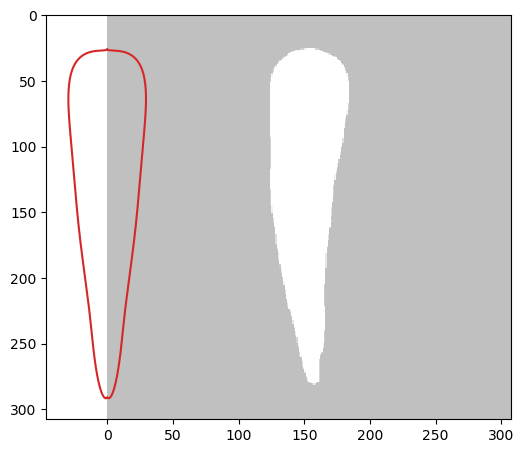

In [23]:
fc =reformRadish(3)
fc

........................
Pair Detection Complete
欠Width Samples Collected

.......
[[0.0, 0.0], [54.77907714709612, -11.622421462311545], [135.5047250680864, 59.76324858957619], [65.5518065710164, -192.45298249708165], [487.86845190540083, 457.6937363410175], [-176.47948333455244, 31.269668761134884], [46.041712248632535, 67.6895361378717], [24.33760962086804, 248.11574645866793], [0.0, 256.0]]
補正後の全長は 256.5 pixels
最大幅は 144.0 pixels


Matrix([
[              24.337609620868*t**7*(8 - 8*t) + 1289.16794296171*t**6*(1 - t)**2 - 9882.85106673494*t**5*(1 - t)**3 + 34150.7916333781*t**4*(1 - t)**4 + 3670.90116797692*t**3*(1 - t)**5 + 3794.13230190642*t**2*(1 - t)**6 + 438.232617176769*t*(1 - t)**7],
[256.0*t**8 + 248.115746458668*t**7*(8 - 8*t) + 1895.30701186041*t**6*(1 - t)**2 + 1751.10145062355*t**5*(1 - t)**3 + 32038.5615438712*t**4*(1 - t)**4 - 10777.3670198366*t**3*(1 - t)**5 + 1673.37096050813*t**2*(1 - t)**6 - 92.9793716984924*t*(1 - t)**7]])

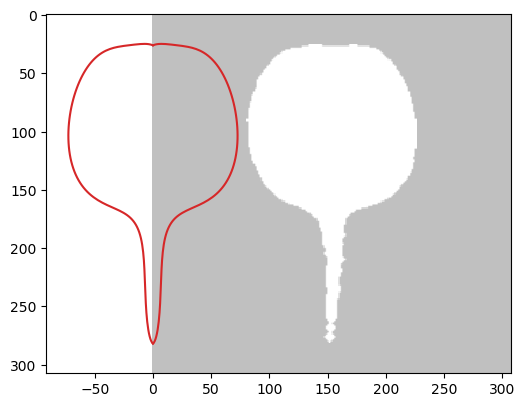

In [24]:
fc =reformRadish(4,N=8)
fc

........................
Pair Detection Complete
欠Width Samples Collected

.....
[[0.0, 0.0], [39.536223900189974, 4.506909370106303], [-2.3414469220762615, -55.82881489536378], [300.9942538255557, 259.8015160810317], [-211.35692377097877, -671.8022326996315], [590.3661739375871, 1372.7716149139712], [-460.23971603076984, -1456.1159363994445], [580.442859516713, 1580.1076128037766], [-191.54850322800343, -847.5719486320694], [284.6801150767396, 822.1395545574157], [-49.39390583393037, -19.21014262074742], [40.09086576837302, 279.5686459506991], [0.0, 256.0]]
補正後の全長は 256.4 pixels
最大幅は 106.0 pixels


Matrix([
[                40.090865768373*t**11*(12 - 12*t) - 3259.9977850394*t**10*(1 - t)**2 + 62629.6253168827*t**9*(1 - t)**3 - 94816.5090978617*t**8*(1 - t)**4 + 459710.744737237*t**7*(1 - t)**5 - 425261.497612431*t**6*(1 - t)**6 + 467570.009758569*t**5*(1 - t)**7 - 104621.677266634*t**4*(1 - t)**8 + 66218.7358416223*t**3*(1 - t)**9 - 154.535496857033*t**2*(1 - t)**10 + 474.43468680228*t*(1 - t)**11],
[256.0*t**12 + 279.568645950699*t**11*(12 - 12*t) - 1267.86941296933*t**10*(1 - t)**2 + 180870.702002631*t**9*(1 - t)**3 - 419548.114572874*t**8*(1 - t)**4 + 1251445.22934059*t**7*(1 - t)**5 - 1345451.12523309*t**6*(1 - t)**6 + 1087235.11901187*t**5*(1 - t)**7 - 332542.105186318*t**4*(1 - t)**8 + 57156.333537827*t**3*(1 - t)**9 - 3684.70178309401*t**2*(1 - t)**10 + 54.0829124412756*t*(1 - t)**11]])

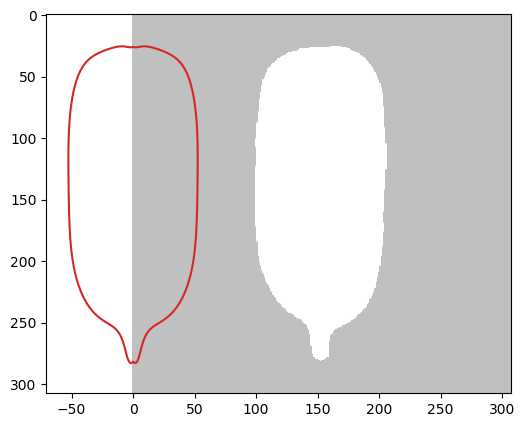

In [25]:
fc =reformRadish(5,N=12)
fc

........................
Pair Detection Complete
Width Samples Collected

..........
[[0.0, 0.0], [47.75910993680495, -4.213997637197234], [1.8241193918497116, 54.61835914447582], [619.7817008896294, -167.7161701520939], [-1016.8416663251027, 590.849809317481], [1550.6198774682266, -428.76201971087215], [-1078.3045404082814, 537.285149724664], [1043.262005201621, 248.17361288340265], [-366.27763840372234, 145.73474343707161], [100.46889328198667, 257.8884818449857], [0.0, 268.0]]
補正後の全長は 268.3 pixels
最大幅は 137.7 pixels


Matrix([
[              100.468893281987*t**9*(10 - 10*t) - 16482.4937281675*t**8*(1 - t)**2 + 125191.440624195*t**7*(1 - t)**3 - 226443.953485739*t**6*(1 - t)**4 + 390756.209121993*t**5*(1 - t)**5 - 213536.749928272*t**4*(1 - t)**6 + 74373.8041067555*t**3*(1 - t)**7 + 82.085372633237*t**2*(1 - t)**8 + 477.591099368049*t*(1 - t)**9],
[268.0*t**10 + 257.888481844986*t**9*(10 - 10*t) + 6558.06345466822*t**8*(1 - t)**2 + 29780.8335460083*t**7*(1 - t)**3 + 112829.881442179*t**6*(1 - t)**4 - 108048.02896714*t**5*(1 - t)**5 + 124078.459956671*t**4*(1 - t)**6 - 20125.9404182513*t**3*(1 - t)**7 + 2457.82616150141*t**2*(1 - t)**8 - 42.1399763719723*t*(1 - t)**9]])

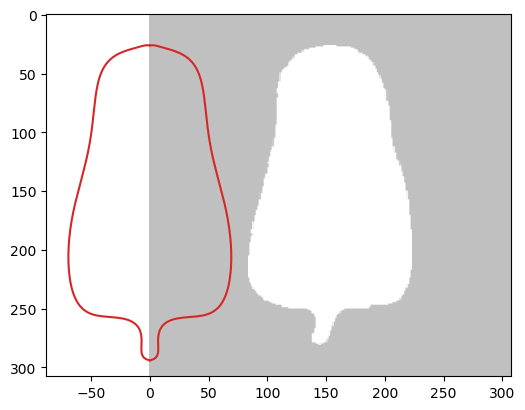

In [26]:
fc =reformRadish(6,N=10)
fc

........................
Pair Detection Complete
Width Samples Collected

.....
[[0.0, 0.0], [71.95406984660954, 0.4266577552145002], [-49.293560746624884, 7.536704229632102], [319.80875199063775, 248.38763961777363], [-226.45598759838703, -145.79684392350393], [338.46035343251555, 442.01589200551626], [-47.81840793254809, 76.7989225553355], [45.631188802734485, 273.4749258578683], [0.0, 266.0]]
補正後の全長は 265.9 pixels
最大幅は 75.0 pixels


Matrix([
[            45.6311888027345*t**7*(8 - 8*t) - 1338.91542211135*t**6*(1 - t)**2 + 18953.7797922209*t**5*(1 - t)**3 - 15851.9191318871*t**4*(1 - t)**4 + 17909.2901114757*t**3*(1 - t)**5 - 1380.2197009055*t**2*(1 - t)**6 + 575.632558772876*t*(1 - t)**7],
[266.0*t**8 + 273.474925857868*t**7*(8 - 8*t) + 2150.36983154939*t**6*(1 - t)**2 + 24752.8899523089*t**5*(1 - t)**3 - 10205.7790746453*t**4*(1 - t)**4 + 13909.7078185953*t**3*(1 - t)**5 + 211.027718429699*t**2*(1 - t)**6 + 3.413262041716*t*(1 - t)**7]])

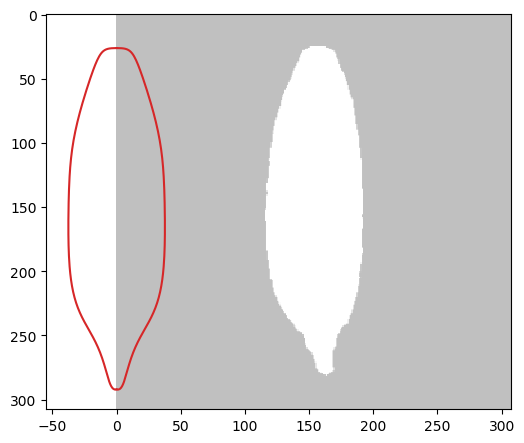

In [27]:
fc =reformRadish(7)
fc

........................
Pair Detection Complete
Width Samples Collected

........
[[0.0, 0.0], [59.357115741790814, 19.65435291741695], [32.895073980207044, -118.13169448190989], [128.07548155032657, 450.42108914743926], [-89.9354416777678, -344.71153195357505], [224.80989925933272, 540.728375952061], [-81.88242660963631, 13.127977649555252], [38.85119239229189, 284.9951859249799], [0.0, 264.0]]
補正後の全長は 263.8 pixels
最大幅は 52.0 pixels


Matrix([
[            38.8511923922919*t**7*(8 - 8*t) - 2292.70794506982*t**6*(1 - t)**2 + 12589.3543585226*t**5*(1 - t)**3 - 6295.48091744375*t**4*(1 - t)**4 + 7172.22696681829*t**3*(1 - t)**5 + 921.062071445797*t**2*(1 - t)**6 + 474.856925934327*t*(1 - t)**7],
[264.0*t**8 + 284.99518592498*t**7*(8 - 8*t) + 367.583374187547*t**6*(1 - t)**2 + 30280.7890533154*t**5*(1 - t)**3 - 24129.8072367503*t**4*(1 - t)**4 + 25223.5809922566*t**3*(1 - t)**5 - 3307.68744549348*t**2*(1 - t)**6 + 157.234823339336*t*(1 - t)**7]])

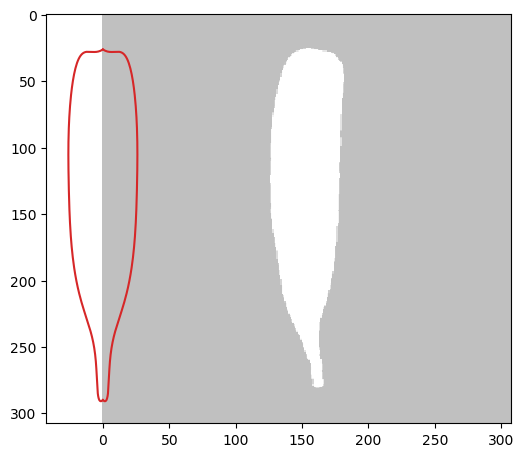

In [28]:
fc =reformRadish(8)
fc

# ベジエ曲線のあてはめの意義

ベジエ曲線はフーリエ記述子などと違って、一度の計算で低次から高次の記述子が一気に算出できるとかいうことはなくて、次数を変えると再計算が必要になるし、記述の一部を使えばおおまかな近似形状が得られるとか、回転や拡大縮小に対する不変性を有するなどの利点はない。

あてはめ次数を決めた場合の制御点の位置で品種が識別できる、などの可能性はなくはないが、識別特徴としての利用は期待薄な気がする。

では何の利点もないかというと、そうではなく、いったん記述ができてしまえば、数式上で変形操作を施したり、微分計算が行えたり、さまざまな条件で計測が行えるというメリットがある。

**Significance of Bézier Curve Fitting**

>Unlike Fourier descriptors, the Bézier curve does not allow you to compute low to high order descriptors at once, and you need to recalculate when you change the order, and it does not have any advantages such as a rough approximation by using a part of the descriptor, or invariance to rotation and scaling.

>There is a possibility that a variety can be identified by the position of the control point when the fitting order is determined, but its use as a discriminative feature is not promising.

>Once a description is made, it has the advantage of being able to perform deformation operations on a mathematical formula, perform differential calculations, and make measurements under various conditions.